https://www.kaggle.com/bananuhbeatdown/logistic-regression-and-knn-predictors

## Exploratory analysis of cash approaches to identify association between a supporters behaviour and likelihood of donating and Logistic Regression & KNN models  

The data sample includes DM cash appeals from 2014 and subsequently supporters approached via those campaign codes (no special treatment has been applied to understand if the appeal was emergency or core, Christmas or otherwise).  The data was then refined to only include one instance per supporter - leaving the most recent approach per supporter.  This was done to remove any bias that might be learnt from supporters we tend to approach more often.  The data was generated using the script "K058 Learning data sample" in the working folder of project K058.  

Since the outcome is binary I would like to explore a logistic regression model and K-Nearest Neighbour - KNN might be better if only one or two features are capable of splitting/ categorising suporter into donate/ does not donate. Whilst logistic regression is better suited to data that is highly correlated.

<img src = "class vs reg.png">

In [1]:
import pypyodbc , pandas as pd ## I ran "pip install pypyodbc" from the command line 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
%matplotlib inline 

pd.options.mode.chained_assignment = None  # default='warn', this turns off warnings about slicing data 

In [2]:
# Importing data
connection = pypyodbc.connect('Driver={SQL Server};'
                              'Server="enter server name";'
                              'Database = analystdata;'
                              'Trusted_Connection=yes;')
cursor = connection.cursor()

SQLCommand = ("select * from analystdata.dbo.K058_cashApproached") 
cursor.execute(SQLCommand) 

columns = [column[0] for column in cursor.description]
data= cursor.fetchall()

for i in range(0,len(data)):
    data[i]=tuple(data[i])
    
df = pd.DataFrame(data, columns = columns)
connection.close()

In [4]:
df.head()
# dropping columns which aren't predictors 
cols_to_drop = ['activitycode', 'campaignname','nlcode','lalmsreferencecode','idcontact','dateprinted','segmentreference',
               'trader','publicfr','postcode',
               'approachesl3mths','approachesl6mths','approachesl12mths'] # approaches were used to create the ratio fields and aren't predictors themselves.
df.drop(cols_to_drop, axis =1, inplace=True,)

df['mosaicgrp'] = df['mosaic'].str[:1]


In [5]:
df.head(2)
rr= df.responded.value_counts()

print(rr)
print(rr.iloc[1]/len(df)*100,'% of the sample responded to cash asks.')

# df.shape 

0    317301
1      7094
Name: responded, dtype: int64
2.18684011776 % of the sample responded to cash asks.


### Analysing binary features

In [27]:
##describing integer flags 
df[['haspledge','hadpledge','gaflag','onlygivestoemer','firstdonationemer','campaigner']].mean()

haspledge              0.545
hadpledge               0.21
gaflag                 0.681
onlygivestoemer            0
firstdonationemer   0.000586
campaigner            0.0416
dtype: float64

The mean values for "has pledge", "had pledge" and "ga flag" show that slightly over half of the sample currently have a pledge, only 20% of the sample have previously had a pledge and 68% have a gift aid declaration.  

Interestingly none of the sample only give to an emergency **CHECK THIS, but for now not including the feature** and a very small proportion of the sample were recruited via an emergency appeal, as confirmed by the "first donation emer" flag having a mean of 0.05%  

c.4% of the sample are campaigners - which is probably too small to helpfully explain enough observations, however campaigners have a 6% response rate (see below) compared to 2% for non-compaigners...

In [28]:
pd.options.display.float_format = '{:.2f}%'.format
print(pd.crosstab(df.responded, df.campaigner))

pd.crosstab(df.responded,df.campaigner).apply(lambda r: r/r.sum()*100, axis=0)

campaigner       0      1
responded                
0           304637  12664
1             6259    835


campaigner,0,1
responded,,
0,97.99%,93.81%
1,2.01%,6.19%


If you **don't have a pledge you are more likely to respond** - 2.8% response vs 1.6% if you do have a pledge...

In [23]:
print(pd.crosstab(df.responded, df.haspledge))
pd.crosstab(df.responded,df.haspledge).apply(lambda r: r/r.sum()*100, axis=0) # axis = 1/0, 
                                                                          # calculates proportion horizontally/vertically

haspledge       0       1
responded                
0          143460  173841
1            4260    2834


haspledge,0,1
responded,,
0,97.12%,98.40%
1,2.88%,1.60%


The same applies if you've previously had a pledge (i.e. it's now inactive), although the distinction is less discriminatory - 2.3% haven't had a pledge vs 1.7% response amongst those that have...

In [22]:
print(pd.crosstab(df.responded, df.hadpledge))
pd.crosstab(df.responded,df.hadpledge).apply(lambda r: r/r.sum()*100, axis=0)

hadpledge       0      1
responded               
0          250514  66787
1            5915   1179


hadpledge,0,1
responded,,
0,97.69%,98.27%
1,2.31%,1.73%


Supporters are more likely to donate if they have a **gift aid declaration ** - is this misleading? Donor's will have a gift aid declaration if they have donated previously. So this might be an indication of loyalty rather than a predictor of giving...

In [21]:
print(pd.crosstab(df.responded, df.gaflag))
pd.crosstab(df.responded,df.gaflag).apply(lambda r: r/r.sum()*100, axis=0)

gaflag          0       1
responded                
0          101343  215958
1            2056    5038


gaflag,0,1
responded,,
0,98.01%,97.72%
1,1.99%,2.28%


### Analysing continuous features

The median **Months since last donation** for **responders** is 6, with a lower quartile of 2 and upper quartile of 13.  
In contrast **non-responders** have a median of 27 months since their last donation and an upper quartile of 82 months.  

Both responders and non-responders have a large standard deviation (30 & 50, respectively) which suggests a wide range of variance from the mean - what we can say is that you haven't donated in the last 46 months (mean +1std dev) then you're not likely to respond.

In [29]:
pd.options.display.float_format = '{:.3f}'.format
df['mthssincelastdonation'].groupby(by = df.responded).describe()
# df['mthssincelastdonation'].groupby(by = df.responded).

responded       
0          count   94170.000
           mean       49.627
           std        53.252
           min         0.000
           25%         6.000
           50%        27.000
           75%        82.000
           max       228.000
1          count    6226.000
           mean       16.814
           std        30.823
           min         0.000
           25%         2.000
           50%         6.000
           75%        13.000
           max       223.000
Name: mthssincelastdonation, dtype: float64

Using ** Months since last donation **, the box plot below shows that responders are more likely to have responded recently...   

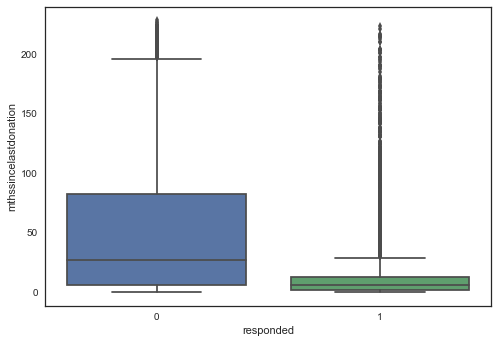

In [6]:
sns.set(style='white')
sns.boxplot(x='responded', y='mthssincelastdonation',data =df)

The box plot below compares the **months since last ask** for the responders and non-responders.  It shows that the two groups are getting roughly the same number of asks, on average an **ask every 1.5 months**.  Whilst this feature won't be helpful in splitting responders/non-responders it's good to know that both groups are getting the same treatment; we're asking the non-responders but they're just not giving.

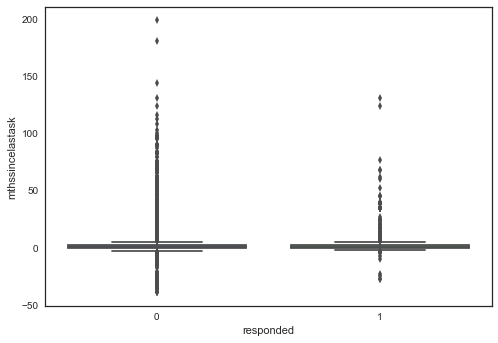

In [26]:
sns.boxplot(x='responded', y='mthssincelastask',data =df)

The **ratio of responses to asks** (number of responses/ number of asks) across the last 3, 6 and 12 months share similar summary statistics;  On **average supporters are roughly responding to 1 in 5 asks**.  The median is 0, which tells us that the most frequent response is no response - which isn't surprising given a response rate of c.2%.

*nb values are null if the supporter hasn't been asked*, this accounts for the majority of the file, over 220k of the 320k records.

In [55]:
print('not asked in last 3 mths: ',df.ratioaskstoresponsel3mths.isnull().sum())
print('not asked in last 6 mths: ',df.ratioaskstoresponsel6mths.isnull().sum())
print('not asked in last 12 mths: ',df.ratioaskstoresponsel12mths.isnull().sum())
print('total sample size: ', len(df))
df[['ratioaskstoresponsel3mths','ratioaskstoresponsel6mths','ratioaskstoresponsel12mths']].describe()

not asked in last 3 mths:  228306
not asked in last 6 mths:  226304
not asked in last 12 mths:  225611
total sample size:  324395


,ratioaskstoresponsel3mths,ratioaskstoresponsel6mths,ratioaskstoresponsel12mths
count,96089.00,98091.00,98784.00
mean,0.21,0.23,0.23
std,0.67,0.76,0.79
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.17,0.14
max,9.00,8.00,19.00


The plot below shows that responders have a history of responding more, as indicated by a higher ratio. Although a sizeable amount have a ratio of 0 which means they haven't responded in the period of time analysed (3, 6 or 12 mths).  Remember that this feature can only explain 30% of the sample at best, because of the high number of nulls/ not approached.

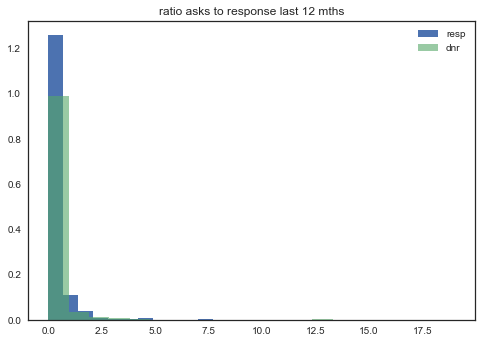

In [105]:
plt.hist(df['ratioaskstoresponsel12mths'][df.responded==1].dropna(), label = 'resp', normed=True, bins=20)
plt.hist(df['ratioaskstoresponsel12mths'][df.responded==0].dropna(), label = 'dnr',alpha=0.6,  normed=True, bins=20)
plt.title('ratio asks to response last 12 mths')
plt.legend()
plt.show()

The below analyses only **core** asks to responses rate, and displays an identical distribution.

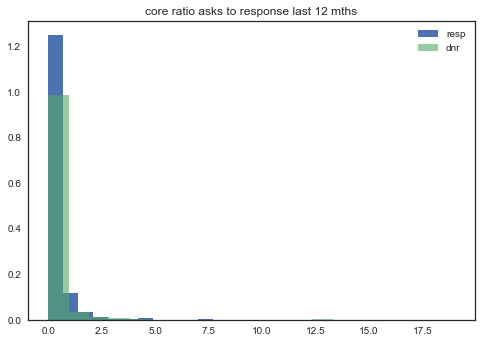

In [106]:
df[['coreratioaskstoresponsel3mths','coreratioaskstoresponsel6mths','coreratioaskstoresponsel12mths']].describe()
plt.hist(df['coreratioaskstoresponsel12mths'][df.responded==1].dropna(), label = 'resp', normed=True, bins=20)
plt.hist(df['coreratioaskstoresponsel12mths'][df.responded==0].dropna(), label = 'dnr',alpha=0.6,  normed=True, bins=20)
plt.title('core ratio asks to response last 12 mths')
plt.legend()
plt.show()

### Analysing categorical features 

Mosaic groups E,L & C have responses greater than 3%, a sizeable improvement of the average response of 2.1%.  

In contrast, O,I & K are less than half the average response.  

The pct_total column confirms that each mosaic group holds a sufficient proportion of the total to be a good predictor.

In [4]:
mosaic_resp = pd.crosstab(df.mosaicgrp,df.responded).apply(lambda r: 100*r/r.sum(), axis=1)
mosaic_counts = df['gaflag'].groupby(df.mosaicgrp).agg({'counts': 'count'}) #gaflag is arbitrary here, it's like doing count(*)
mosaic_counts['pct_total'] =mosaic_counts.apply(lambda r: 100*r/r.sum())
mosaic_counts['rr'] =mosaic_resp[1]
mosaic_counts.sort_values('rr', ascending=False)

# selecting specific columns 
# mosaic_counts.iloc[:,1:3].sort_values(by='rr')

,counts,pct_total,rr
mosaicgrp,,,
E,28146,8.730636,3.815818
L,14584,4.523826,3.174712
C,28733,8.912718,3.000035
B,39968,12.397715,2.942354
F,17613,5.463394,2.776358
D,19291,5.983895,2.358613
G,31813,9.868107,2.134348
M,9585,2.973181,1.836202
H,20140,6.247247,1.762661


Aggregating mosaic into ** Audience ** profiles shows less discrimination across response rate... WW have the highest response of 3%, where as mosaic above could identify segments that achieve close to 4% response and 0.7%

In [213]:
aud_resp = pd.crosstab(df.audienceprofile2016,df.responded).apply(lambda r: 100*r/r.sum(), axis=1)
aud_counts = df['gaflag'].groupby(df.audienceprofile2016).agg({'counts': 'count'})
aud_counts['pct_total'] =aud_counts.apply(lambda r: 100*r/r.sum())
aud_counts['rr'] =aud_resp[1]
aud_counts.sort_values('rr', ascending=False)

,counts,pct_total,rr
audienceprofile2016,,,
Wealthy Wellwishers,46696,14.395,2.979
Rapid Responders,56297,17.354,2.602
Not in target,139797,43.095,1.994
Upwardly Urban,66098,20.376,1.826
Mindful Mums,13494,4.160,1.586
Unclassified,2013,0.621,1.441


** Creating dummies for mosaic ** 

In [241]:
df.mosaic.isnull().sum()

2013

In [6]:
mosaic = pd.get_dummies(df.mosaicgrp)
mosaic.columns = ['mosaic_' + str(i) for i in mosaic.columns]

## shortlist of features from univariate analysis above 
features = ['responded','mthssincelastdonation','campaigner','gaflag','haspledge','ratioaskstoresponsel12mths']
model = df[features]
model= model.join(mosaic.iloc[:,:14]) # dropping mosaic_O
model.head()

,responded,mthssincelastdonation,campaigner,gaflag,haspledge,ratioaskstoresponsel12mths,mosaic_A,mosaic_B,mosaic_C,mosaic_D,mosaic_E,mosaic_F,mosaic_G,mosaic_H,mosaic_I,mosaic_J,mosaic_K,mosaic_L,mosaic_M,mosaic_N
0,0,86.0,0,1,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,3.0,1,0,1,0.142857,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.0,0,1,1,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,19.0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,3.0,0,1,0,0.400000,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Create logistic regression

In [7]:
##logistic regression doesn't like nulls, so filling...

model['mthssincelastdonation'].fillna(999,inplace=True) # null = no previous cash, 0 = gave cash in the current mth as the ask
                                                        # because this is a continuous variable the null value needs to be 
                                                        # monotonic with the existing values

        # calc binary flag to see if thats useful
model['nopreviouscash'] = model.mthssincelastdonation.apply(lambda x: 1 if x == 999 else 0) 


## NB DON'T WORRY ABOUT THIS CODE AS ratioaskstoresponsel12mths DOESNT MAKE IT INTO THE FINAL MODEL.
##repeating for ratio of asks to responses;
# ratioaskstoresponsel12mths
# null = not asked 
# 0 = not responded 
# >0 responded to an increasing extent 
# therefore nulls need to be a low number so setting to -1

# model['ratioaskstoresponsel12mths'].fillna(-1,inplace=True)


# chi2 (used to calc p-value) can't handle negatives, so to avoid use of -1, I've reversed the values of 
# ratioaskstoresponsel12mths by subtracting the max value.
# 19 = max, so 
# 20 = nulls
# 19 = no responses 
# 18.8 = gave 20% of the time (0.2) 
# now 0 can be used to override nulls and there is still an order to the values that is meaningful and negative values are 
# avoided.


reverse_val = df.ratioaskstoresponsel12mths.max()
model['ratioaskstoresponsel12mths_reversed'] = reverse_val - model['ratioaskstoresponsel12mths']
model['ratioaskstoresponsel12mths_reversed'].fillna(reverse_val+1, inplace=True) 

# model['notasked'] = model.mthssincelastdonation.apply(lambda x: 1 if x == -1 else 0) 


In [6]:
model[['ratioaskstoresponsel12mths','ratioaskstoresponsel12mths_reversed']].head(5)

,ratioaskstoresponsel12mths,ratioaskstoresponsel12mths_reversed
0,NaN,20.000000
1,0.142857,18.857143
2,NaN,20.000000
3,NaN,20.000000
4,0.400000,18.600000


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(model, test_size = 0.2, random_state =5)

** Fitting a logistic regression model ** 

In [38]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression()
y = train[['responded']]

#1st interation 
# X = train.iloc[:,1:22].drop('ratioaskstoresponsel12mths', axis=1) #cutting responded from the first column
                             
                             
#2nd iteration after filtering high p-values 
# X = train.iloc[:,1:22].drop(['ratioaskstoresponsel12mths','mosaic_D', 'mosaic_G'], axis=1)

#3rd iteration after calculating information value below
X = train[predictive.Variable] # predictive is the output from IV calc further down

lm.fit(X,y)

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
from sklearn import metrics
test['y_pred'] = lm.predict(test[X.columns]) 
print('accuracy at default 0.5 threshold :',metrics.accuracy_score(test.responded, test.y_pred))

accuracy at default 0.5 threshold : 0.977881903235


 The accuracy is really high, but at a treshold of 0.5 the table below confirms that the model doest predict any responses! So the threshold needs to be adjusted using a ROC curve.

In [14]:
# (y_pred == test.responded).value_counts()
pd.crosstab(test.responded,test.y_pred)

y_pred,0
responded,
0,63444
1,1435


** Cross validation ** 

In [13]:
from sklearn.cross_validation import KFold, cross_val_score

# split the dataset using K-folds
kf = KFold(len(train), n_folds=10, shuffle=False)

print('mean auc from Cv folds:', 
      cross_val_score(lm, # this is estimator above.
                      X,
                      train['responded'],
                      scoring = 'roc_auc',
                      cv=kf).mean())

##using cross_val_score is the equivalent of saying (this is pseudo code);
# lm.fit(X[train_indices], y[train_indices]). #train on the training cv 
#                        score(X[test_indices],y[test_indices]) # validate on the test cv



C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


mean auc from Cv folds: 0.851112076859


I wanted to understand why the fit command could be applied first and cross validaton second and realised that cross validation will inevitably use all of the training set to build the model, so cross validation doesn't alter the model fit. But each 'test' fold is used to validate the models ability to fit different cross sections of the data - I guess the clues in the name - cross VALIDATION.

### Testing LogisticRegressionCV
I also came across LogisticRegressionCV estimator and thought encorporating CV might be more efficient.  
Unlike LogisticRegression() the CV estimator also searches different C values (generalising the model and adding an amount of error which improves the models performance on unseen data).   
Cs values by default use the value 10 and take ten values in a logarithmic scale between 1e-4 and 1e4 - this is all well documented on sklearn.  
The *refit* param defaults to True, this means that the best estimator is used to calculated the scores_ and coefficients_

In [16]:
## Just out of curiosity using LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV
lm2 = LogisticRegressionCV(cv= kf, 
                           Cs=list(np.power(10.0, np.arange(-10, 10))), 
                           scoring='roc_auc',
                           random_state=5)
lm2.fit(X,train['responded'])

lm2.scores_[1].mean() #0.85503718002197249
# taking the mean above is the average auc for all C iterations, whilst below takes the average for 
# each C iteration (across 10 folds) and then returns the max, aka the best.
print ('Best auc_roc:', lm2.scores_[1].mean(axis=0).max())  # is correct

Best auc_roc: 0.857761963961


The 0.857 auc is marginally improved from LogisiticRegressionCV compared to 0.851 from the LogisticRegression estimator.  

** The lm2 model will be used from here on as the AUC is greater.** 

** P values ** 

In [12]:
# np.set_printoptions(suppress=True, precision = 4)
from sklearn.feature_selection import chi2
scores, pvalues = chi2(X, y)

for p in range(len(pvalues)):
    print(X.columns[p], pvalues[p])

intercept [-0.05217186]
mthssincelastdonation 0.0
campaigner 5.30072726062e-166
gaflag 0.0132290733538
haspledge 2.49052616778e-54
mosaic_A 3.36757803635e-07
mosaic_B 8.93269141902e-20
mosaic_C 2.01024268749e-18
mosaic_D 0.06708075967
mosaic_E 2.48649635993e-66
mosaic_F 1.5359994151e-05
mosaic_G 0.675552235251
mosaic_H 0.00057265138131
mosaic_I 9.23912645991e-18
mosaic_J 2.937832791e-07
mosaic_K 2.53301620439e-34
mosaic_L 1.85361794101e-13
mosaic_M 0.0359537408121
mosaic_N 1.78579292881e-21
nopreviouscash 0.0
ratioaskstoresponsel12mths_reversed 3.28696011883e-43


Mosaic group D & G aren't signficant - removed these features from the model fit higher up the code. 

** Feature predictiveness ** using information value

In [10]:
# defining a function 
def IV(feature, outcome, data):
    #d - dist, 1/0= legate/dnl, 1/0 = feature true or false 
    d11= data.iloc[:,0][(data[feature]==1) & (data[outcome]==1) ].count()/ data.iloc[:,0][data[outcome]==1].count()
    d10= data.iloc[:,0][(data[feature]==0) & (data[outcome]==1) ].count()/ data.iloc[:,0][data[outcome]==1].count()

    d01=data.iloc[:,0][(data[feature]==1) & (data[outcome]==0) ].count()/ data.iloc[:,0][data[outcome]==0].count()
    d00=data.iloc[:,0][(data[feature]==0) & (data[outcome]==0) ].count()/ data.iloc[:,0][data[outcome]==0].count()
    
    woe_true = np.log(d10/d00)
    woe_false = np.log(d11/d01)
    dist_true = d10-d00
    dist_false = d11-d01
    IV = woe_true * dist_true + woe_false * dist_false
    if IV > 0.3:
        status = 'strong'
    elif IV >=0.1:
        status ='medium'
    elif IV >=0.02:
        status = 'weak'
    else:
        status ='unpredictive'
            
    return IV #print(feature, ':',status, ":", IV ) # uncomment this and below to print out all values:

# for f in X[sig.Variable]:
#     IV(f,'legatorflag',train)

In [17]:
## Calculating Information Value for significant variables.
i = []
for var in X.columns:
    i.append({'Variable': X[var].name, 
              'IV': IV(var,'responded',train)})

df_i= pd.DataFrame(i)

predictive = df_i[(df_i['IV']>=0.02)] ## keeping anything that is weak or above
df_i.sort_values('IV', ascending =False)

,IV,Variable
7,1.639071,nopreviouscash
0,0.178262,mthssincelastdonation
2,0.095975,haspledge
1,0.085870,campaigner
5,0.045785,mosaic_K
3,0.045285,mosaic_E
6,0.023158,mosaic_N
4,0.020176,mosaic_I


Adjusted "X" in the model fit further up the code and referred to the "predictive" subset of features 

** Coefficients ** 

In [41]:
#LogisticRegression
coef = []
for n in range(len(X.columns)):
     coef.append({'Variable': X.columns[n], 'coef': lm2.coef_[:,n]})
print("intercept:", lm2.intercept_) 
coef 

intercept: [-2.55679906]


[{'Variable': 'mthssincelastdonation', 'coef': array([-0.00319615])},
 {'Variable': 'campaigner', 'coef': array([ 0.02477129])},
 {'Variable': 'haspledge', 'coef': array([-0.00200749])},
 {'Variable': 'mosaic_E', 'coef': array([ 0.01023512])},
 {'Variable': 'mosaic_I', 'coef': array([-0.00186041])},
 {'Variable': 'mosaic_K', 'coef': array([-0.00277686])},
 {'Variable': 'mosaic_N', 'coef': array([-0.00458025])},
 {'Variable': 'nopreviouscash', 'coef': array([ 0.01057965])}]

The coefficients above are expressed in Log Odds.  Each unit increase in X (predictor) results in a change to the log odds by the value of the coefficient. If the coefficient is positive then increasing X will result in an increasing probability, if the coefficient is negative then increasing X will result in a decreasing p(X).  

If the coefficient for campaigner is 0.02 - the value is positive so if you are a Campaigner then the probability of donating will increase; Campaigner is a binary 1 or 0 flag.

Converting odds to probability  = p(X)/ 1-p(X)

Probability of leaving a legacy if you are a Campaigner =   
(this is for illustration only, as the coefficient for Miss must be used in the context of all other coefficients)   
p(Donate) = exp(intercept+coef x 1)   
		/ 1+exp(intercept+coef x 1)  
        
p(Legacy) where *Campaigner =1*  
= exp(-2.55 + 0.02 x 1)/1+exp(-2.49 + 0.02 x 1)   
= 0.023639  
= **7.4% chance ** that the supporter will donate.

p(Legacy) where *Miss =0*  
= exp(-2.55 + 0.02 x 0)/1+exp(-2.49 + 0.02 x 0)   
= 0.023639  
= ** 7.2% chance ** that the supporter will donate.


### Area under the Curve (AUC) - test data

test auc 0.858910022326


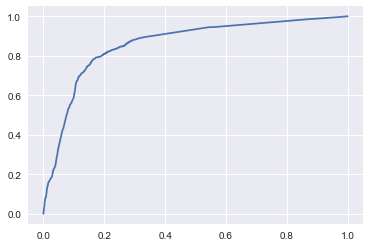

In [18]:
from sklearn.metrics import (roc_curve, roc_auc_score,)

test['y_prob'] =lm2.predict_proba(test[predictive.Variable])[:,1]

plt.plot(roc_curve(test.responded, test.y_prob)[0], roc_curve(test.responded, test.y_prob)[1])
print('test auc', roc_auc_score(test.responded, test.y_prob)) 

AUC is acceptably high, the CV auc was also 0.85, so this tells us that the model is effective at predicting donate/does not donate on the unseen test data.

In [19]:
## Finding out the threshold at different rates of FPR
roc= pd.DataFrame(roc_curve(test.responded, test.y_prob)[0]) #tpr
roc = roc.rename(index=str,columns={0:'fpr'})
roc['tpr']= roc_curve(test.responded, test.y_prob)[1] #tpr
roc['threshold']= roc_curve(test.responded, test.y_prob)[2] #threshold

roc[roc.fpr>=0.25].head(1)

,fpr,tpr,threshold
1063,0.25,0.844599,0.051273


In [42]:
## redoing prediction based on above threshold 
test['y_pred']= test.y_prob.apply(lambda x: 1 if x>=0.051273 else 0) 
print('accuracy: ',metrics.accuracy_score(test.responded, test.y_pred))
pd.crosstab(test.responded,test.y_pred)

accuracy:  0.752554755776


y_pred,0,1
responded,,
0,47613,15831
1,223,1212


Accuracy drops as the model starts to make predictions on who will donate - this is to be expected.  if the model made no predictions and assumed nobody responded the accuracy would be 97.9% - because only 2.1% donate.  

Adjusting the **treshold to 0.051273**  the model misses 223 of 1,435 (15%) true donations.  
The model incorrectly identifies 15,831 supporters who will donate, this sounds high, but actually the models ability to correctly exclude 47,605 of non-responders presents a sizeable cost saving to the DM cash programme... 

Assuming each mail pack costs £1 and each donation is £20;  

||cost|income|ROI|RR|
|--|--|--|--|--|
|With no model|-£65k|£29k|0.4|2.1%|
|Threshold 0.051|-£17k|£24k|1.4|7.1%|

If we were to accept the models recommendation and target the "predicted donate" group the response rate would increase to 7.1%, we would receive c.85% of income but would be £43k better off, largely based on a cost saving of £47k.


### Score Distribution

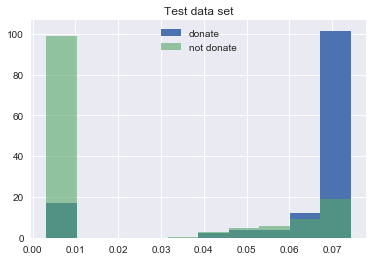

donate 1435
did not donate 63444


In [44]:
plt.hist(test['y_prob'][test.responded==1], label = 'donate', normed=True, bins=10)
plt.hist(test['y_prob'][test.responded==0], label = 'not donate',alpha=0.6, normed=True, bins=10)
plt.title('Test data set')
plt.legend()
plt.show()

print('donate', test['responded'][test.responded==1].count())
print('did not donate', test['responded'][test.responded==0].count())

## KNN 

In [36]:
X.head()

,nopreviouscash,haspledge,campaigner
106685,1,0,0
237597,1,0,0
252813,0,1,0
264941,1,1,0
34412,0,0,0


In [37]:
from sklearn.neighbors import KNeighborsClassifier

X = train[['nopreviouscash','mthssincelastdonation']] # reducing dimensions
y = train['responded']

knn= KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X,y)
train['knn_pred'] = knn.predict(X)


# SHOULD BE ABLE TO DO A FOR LOOP TO  FIND THE OPTIMUM K VALUE, BUT THIS TOOK TOO LONG TO RUN.
# k_values = range(1,20)
# scores = []

# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors=k)                           
                              
#     knn.fit(X, y)
#     scores.append(knn.score(X, y))
# print(scores)

# AN ALTERNATIVE INCLUDING CROSS VALIDATION - AGAIN TAKES TO LONG TO RUN, WOULD LIKE TO SEE IF AUC SCORING IS POSSIBLE.
# for K in k_range:
#     knn = KNeighborsClassifier(n_neighbors=K)
#     scores = cross_val_score(knn, X, y, cv=10, scoring="accuracy")
#     k_scores.append(scores.mean())

# THEN PLOT THE DIFFERENT K VALUES AND SCORES;
# %matplotlib inline

# plt.xlabel = 'K'
# plt.plot(k_values,scores[1::2],)# this is saying start on the 1st row and step 2 
#                                 # i.e. return all odd rows which is using distance


In [32]:
from sklearn import metrics
train.head()

test['knn_pred'] = knn.predict(test[X.columns])
test['knn_prob'] = knn.predict_proba(test[X.columns])

print('accuracy: ',metrics.accuracy_score(test.responded, test.knn_pred))
pd.crosstab(test.responded,test.knn_pred)

accuracy:  0.977881903235


knn_pred,0
responded,
0,63444
1,1435


KNN, like the LR 0.5 threhold, doesn't assign a class 1/ True prediction to any of the observations.    
Does using a different number of neighbours affect this?  

** NB the KNN models below iterating K values takes too long, so haven't sucessfully let it run.  **

In [ ]:
# confirm optimum KNN model - TBC - WASN'T ABLE TO GET THIS FAR AS I COULDN'T TEST K VALUES.
knn = KNeighborsClassifier(n_neighbors=18)
cross_val_score(knn, X, y, cv=10, scoring="accuracy").mean()

It seems that **logistic regression is better suited to this problem**. I would suggest this is because the proportion of responders is relatively small (2% of the sample) and the predictors are not very strong - there isn't a decisive feature that can confidently split responders and non-responders. Furthermore, KNN works best with fewer features, but most of the features are binary.  As KNN uses the distance from the target observation to K neighbours to calculate the probability of each class, then you can imagine a binary value creates a equal distance for many observations, rather than a continous variable that spreads out your observations allowing you to draw a disecting line.  

I think because of the binary nature of most of the features to create some discrimination in the data, we need to use several features - aka better suited to logistic regression, plus a AUC of 85% is perfectly acceptable.

The KNN estimator took a long time to run, so it seems it's a less efficient technique with the volume of data I'm using.